In [1]:
# Import modules

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"   # must happen before importing jax

import argparse
import jax
import numpy as np
import numpyro
from numpyro.infer import Predictive, MCMC, NUTS
import jax.numpy as jnp
from helper import import_dataset, normalize, build_utterance_prior_jax, plot_utterance_distribution, theme_aida
from modelSpecification import likelihood_function_global_speaker, likelihood_function_incremental_speaker, global_speaker, incremental_speaker, incremental_semantics_jax
import matplotlib.pyplot as plt
import seaborn as sns
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
print(jax.__version__)


/Users/heningwang/Documents/GitHub/numpyro_adjective_modelling/jax-metal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2025-11-27 18:35:24.120398: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB

0.4.20
[CpuDevice(id=0)]
0.4.20


In [2]:
# Empirical hard labels
data = import_dataset()
states_train = data["states_train"]
empirical_train = data["empirical_seq_flat"]
utterance_list = data["unique_utterances"]
empirical_dist_by_condition = data["empirical_dist_by_condition"]
df = data["df"]


print("States train shape:", states_train.shape)
print("Empirical train shape:", empirical_train.shape)
# ========================
print("States train:", states_train[0:3])
print("Empirical train:", empirical_train[0:3])

print(df["annotation"][0:3])



States train shape: (3196, 6, 3)
Empirical train shape: (3196,)
States train: [[[ 9.  1.  1.]
  [10.  0.  0.]
  [10.  0.  1.]
  [10.  0.  1.]
  [10.  0.  1.]
  [ 1.  0.  1.]]

 [[ 9.  1.  1.]
  [10.  0.  0.]
  [ 9.  0.  0.]
  [10.  0.  1.]
  [ 9.  0.  0.]
  [ 2.  0.  1.]]

 [[10.  1.  1.]
  [10.  0.  0.]
  [ 3.  1.  0.]
  [ 2.  1.  1.]
  [10.  0.  0.]
  [ 1.  0.  1.]]]
Empirical train: [5 5 2]
1      C
2      C
3    DCF
Name: annotation, dtype: category
Categories (15, object): ['C', 'CD', 'CDF', 'CF', ..., 'FC', 'FCD', 'FD', 'FDC']


  relevant_property sharpness  annotation_seq_flat  count  proportion  \
0              both   blurred                    1     39    0.068905   
1              both   blurred                    2    175    0.309187   
2              both   blurred                    3     48    0.084806   
3              both   blurred                    4     17    0.030035   
4              both   blurred                    5      5    0.008834   

  annotation  
0         DC  
1        DCF  
2         DF  
3        DFC  
4          C  


<Figure size 640x480 with 0 Axes>

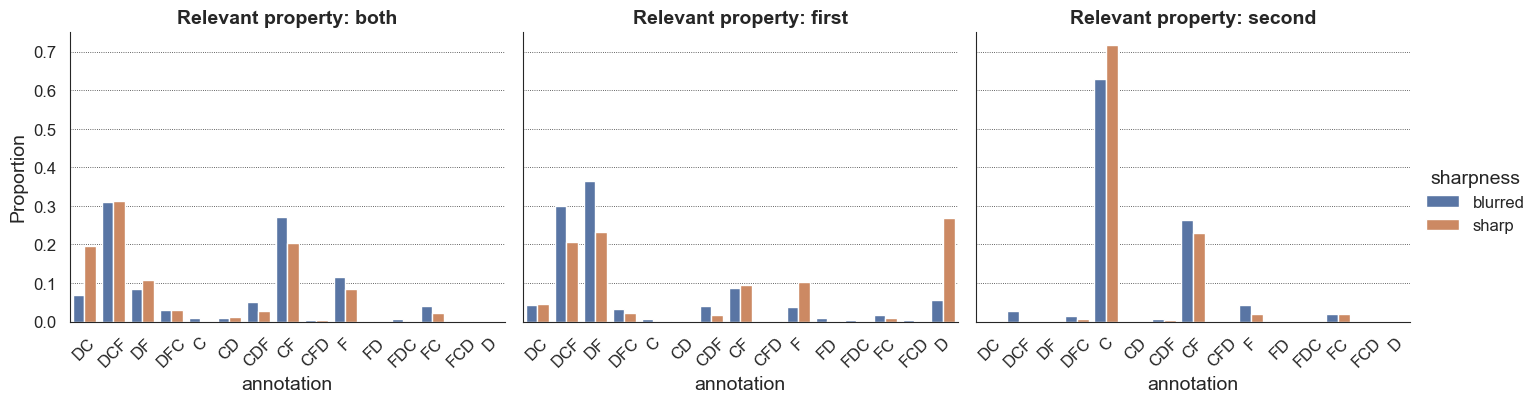

In [3]:
counts = (
    df.groupby(["relevant_property", "sharpness", "annotation_seq_flat"])
      .size()
      .reset_index(name="count")
)

# Compute proportions within each (relevant_property, sharpness) cell
counts["proportion"] = (
    counts.groupby(["relevant_property", "sharpness"])["count"]
          .transform(lambda x: x / x.sum())
)

# Map flat codes to readable annotation labels

FLAT_TO_CATEGORIES= {
    "0": "D",
    "1": "DC",
    "2": "DCF",
    "3": "DF",
    "4": "DFC",
    "5": "C",
    "6": "CD",
    "7": "CDF",
    "8": "CF",
    "9": "CFD",
    "10": "F",
    "11": "FD",
    "12": "FDC",
    "13": "FC",
    "14": "FCD",
}
counts["annotation"] = counts["annotation_seq_flat"].astype(str).map(FLAT_TO_CATEGORIES)

print(counts.head())

theme_cfg = theme_aida(
    title_size=16,
    text_size=14,
    legend_position="top",
    show_axis=False,
    show_grid=True
)


g = sns.catplot(
    data=counts,
    x="annotation",
    y="proportion",
    hue="sharpness",
    col="relevant_property",
    kind="bar",
    height=4,
    aspect=1.2
)
g.set_xticklabels(rotation=45)
g.set_ylabels("Proportion")
g.set_titles("Relevant property: {col_name}")
plt.show()

Example state: [[10.  1.  1.]
 [ 9.  0.  1.]
 [ 1.  1.  1.]
 [ 2.  1.  1.]
 [ 9.  0.  1.]
 [ 2.  0.  1.]]
Example annotation_flat: 2
Example annotation: DCF
Example listener matrix shape: (15, 6)
Example listener matrix: [[0.06261043 0.07374845 0.275349   0.25727183 0.07374845 0.25727183]
 [0.04121879 0.00234377 0.6316238  0.3063464  0.00234377 0.01612349]
 [0.04121879 0.00234377 0.6316238  0.3063464  0.00234377 0.01612349]
 [0.06901827 0.08111853 0.2661213  0.25131166 0.08111853 0.25131166]
 [0.04121879 0.00234377 0.6316238  0.3063464  0.00234377 0.01612349]
 [0.3166667  0.01666667 0.3166667  0.3166667  0.01666667 0.01666667]
 [0.10155213 0.00629567 0.44660732 0.4172867  0.00629567 0.02196246]
 [0.1134764  0.00701953 0.4375434  0.41319412 0.00701953 0.02174706]
 [0.31666666 0.01666667 0.31666666 0.31666666 0.01666667 0.01666667]
 [0.10155213 0.00629567 0.44660735 0.41728675 0.00629567 0.02196246]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.06261043 0.07374

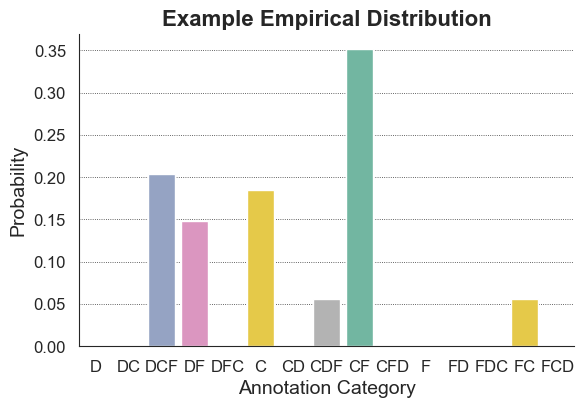

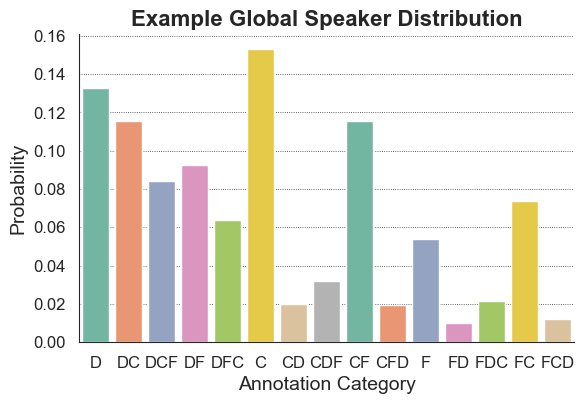

Example incremental speaker shape: [0.16853733 0.07621157 0.05538771 0.06097783 0.05126716 0.19447812
 0.01810375 0.02743671 0.10560898 0.04586205 0.06845756 0.00894518
 0.02266122 0.06753883 0.02852601]


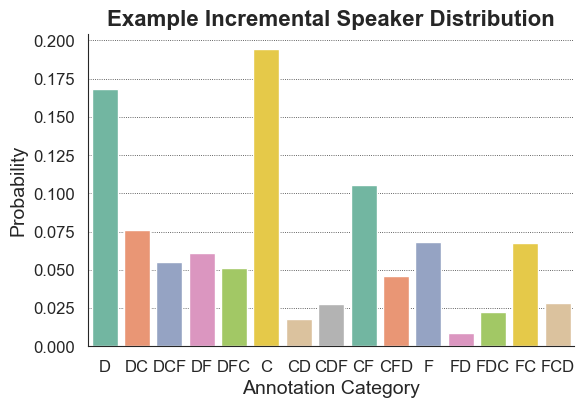

In [4]:
# Print examples
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

example_index = 3
example_state = states_train[example_index]
example_annotation_flat = empirical_train[example_index]
example_annotation = df["annotation"].iloc[example_index]
print("Example state:", example_state)
print("Example annotation_flat:", example_annotation_flat)
print("Example annotation:", example_annotation)
# plot the example empirical distribution as catplot 
# ========================




example_listener_matrix = incremental_semantics_jax(example_state, 0.95, 0.95, 0.5, 0.5)
print("Example listener matrix shape:", example_listener_matrix.shape)
print("Example listener matrix:", example_listener_matrix)
plot_utterance_distribution(empirical_dist_by_condition[example_index], titel="Example Empirical Distribution")
wf = 1
color_semval = 0.5
example_global_speaker = global_speaker(example_state, alpha=2,
                                         wf=wf, color_semval= color_semval, beta=1)
plot_utterance_distribution(example_global_speaker, titel="Example Global Speaker Distribution")
example_incremental_speaker = incremental_speaker(example_state, alpha=2, wf=wf, color_semval=color_semval, beta=1)
print("Example incremental speaker shape:", example_incremental_speaker)
plot_utterance_distribution(example_incremental_speaker, titel="Example Incremental Speaker Distribution")

In [5]:
def draw_samples_from_prior(num_samples: int = 100_000) -> dict:
    """
    Draw parameter samples from the specified priors using NumPy and return them
    as JAX arrays for downstream use.
    """
    rng = np.random.default_rng()
    n = int(num_samples)

    samples = {
        "alpha": np.abs(rng.normal(loc=0.0, scale=2.0, size=n)),
        "color_semval": rng.uniform(0.8, 1.0, size=n),
        "k": rng.uniform(0.0, 0.2, size=n),
        "bias_subjectivity": rng.normal(loc=2 , scale=2.0, size=n),
        "bias_length": rng.normal(loc=1, scale=2.0, size=n),
    }

    return {name: jnp.asarray(values) for name, values in samples.items()}

def generate__prior_predictive_data(prior_samples, num_samples):
    """
    Generate predictive data using the provided posterior samples.
    """
    data = import_dataset()
    states_train = data["states_train"]
    rng_key_ = jax.random.PRNGKey(0)
    predictive = Predictive(likelihood_function_global_speaker, prior_samples)
    predictions = predictive(rng_key_, states_train)["obs"]
    return predictions
    



posterior_samples = draw_samples_from_prior(num_samples=1000)
predictions = generate__prior_predictive_data(posterior_samples, num_samples=1000)

print("Predictions shape:", predictions.shape)  # should be (1000, number of data points)

Predictions shape: (1000, 3196)


In [6]:
import pandas as pd
def compute_proportions_for_draw(pred_row, df):
    """
    Given a single predictive sample (1D array of length n_obs),
    attach it as 'annotation_seq_flat' to df and compute the
    proportions of each annotation category within each
    (relevant_property, sharpness) condition.

    Returns:
        DataFrame with columns:
        ['relevant_property', 'sharpness', 'annotation_seq_flat', 'count', 'proportion']
    """
    # Ensure 1D numpy array
    preds = np.asarray(pred_row).reshape(-1)

    if len(preds) != len(df):
        raise ValueError(
            f"Length mismatch: predictions row has length {len(preds)}, "
            f"but df has {len(df)} rows."
        )

    # Copy df to avoid modifying original
    df_tmp = df.copy()
    df_tmp["annotation_seq_flat"] = preds

    # Count occurrences by condition and category
    counts = (
        df_tmp.groupby(["relevant_property", "sharpness", "annotation_seq_flat"])
              .size()
              .reset_index(name="count")
    )

    # Convert counts to proportions within each (relevant_property, sharpness)
    counts["proportion"] = (
        counts.groupby(["relevant_property", "sharpness"])["count"]
              .transform(lambda x: x / x.sum())
    )

    return counts


def summarize_predictions(predictions, df, annotation_map=None):
    """
    Given a matrix of predictions and a dataframe of conditions,
    compute mean and std of predicted proportions for each
    (relevant_property, sharpness, annotation_seq_flat).

    Args:
        predictions: array-like of shape (n_draws, n_obs)
        df: DataFrame with n_obs rows and at least the columns
            ['relevant_property', 'sharpness'].
        annotation_map: optional dict mapping annotation_seq_flat -> label
                        (e.g., FLAT_TO_CATEGORIES).

    Returns:
        summary: DataFrame with columns:
            ['relevant_property',
             'sharpness',
             'annotation_seq_flat',
             'mean_proportion',
             'std_proportion',
             (optional) 'annotation']
    """
    pred_arr = np.asarray(predictions)
    n_draws, n_obs = pred_arr.shape

    if len(df) != n_obs:
        raise ValueError(
            f"Number of observations mismatch: predictions has {n_obs} columns, "
            f"but df has {len(df)} rows."
        )

    # Compute per-draw proportion tables and stack them
    all_prop_dfs = []
    for i in range(n_draws):
        prop_df = compute_proportions_for_draw(pred_arr[i, :], df)
        prop_df["draw"] = i
        all_prop_dfs.append(prop_df)

    combined = pd.concat(all_prop_dfs, ignore_index=True)

    # Aggregate across draws: mean and std of proportions
    summary = (
        combined.groupby(["relevant_property", "sharpness", "annotation_seq_flat"])
                .agg(
                    mean_proportion=("proportion", "mean"),
                    std_proportion=("proportion", "std")
                )
                .reset_index()
    )

    # Optionally map to human-readable annotation labels
    if annotation_map is not None:
        summary["annotation"] = summary["annotation_seq_flat"].astype(str).map(FLAT_TO_CATEGORIES)

    return summary


# Example usage
summary = summarize_predictions(predictions, df, annotation_map=FLAT_TO_CATEGORIES)
print(summary.head())


  relevant_property sharpness  annotation_seq_flat  mean_proportion  \
0              both   blurred                    0         0.051833   
1              both   blurred                    1         0.074807   
2              both   blurred                    2         0.085209   
3              both   blurred                    3         0.048248   
4              both   blurred                    4         0.076195   

   std_proportion annotation  
0        0.038372          D  
1        0.042406         DC  
2        0.041230        DCF  
3        0.029312         DF  
4        0.033900        DFC  


In [7]:
summary

,relevant_property,sharpness,annotation_seq_flat,mean_proportion,std_proportion,annotation
0,both,blurred,0,0.051833,0.038372,D
1,both,blurred,1,0.074807,0.042406,DC
2,both,blurred,2,0.085209,0.041230,DCF
3,both,blurred,3,0.048248,0.029312,DF
4,both,blurred,4,0.076195,0.033900,DFC
...,...,...,...,...,...,...
85,second,sharp,10,0.033012,0.027226,F
86,second,sharp,11,0.023875,0.019372,FD
87,second,sharp,12,0.058328,0.023381,FDC
88,second,sharp,13,0.097952,0.044543,FC


In [1]:
g = sns.catplot(
    data=summary,
    x="annotation",
    y="mean_proportion",
    hue="sharpness",
    col="relevant_property",
    kind="bar",
    height=4,
    aspect=1.2
)

g.set(ylim=(-0.1, 0.6))
g.set_xticklabels(rotation=45)
g.set_ylabels("Mean Predicted Proportion")
g.set_titles("Relevant property: {col_name}")

axes = np.ravel(g.axes)                  # flatten in case of multiple columns
col_levels = g.col_names                # which facet values we have

for ax, col_val in zip(axes, col_levels):
    sub = summary[summary["relevant_property"] == col_val]

    # Get the order seaborn uses for bars
    x_levels = [t.get_text() for t in ax.get_xticklabels()]
    hue_levels = sorted(sub["sharpness"].unique())

    # Build lookup: (annotation, sharpness) → (mean_proportion, std_proportion)
    stats = {
        (row.annotation, row.sharpness): (row.mean_proportion, row.std_proportion)
        for _, row in sub.iterrows()
    }

    # Iterate over bar patches in seaborn's order
    patch_idx = 0
    for anno in x_levels:
        for sharp in hue_levels:
            patch = ax.patches[patch_idx]
            patch_idx += 1

            if (anno, sharp) not in stats:
                continue

            mean_val, std_val = stats[(anno, sharp)]

            # bar center
            x_center = patch.get_x() + patch.get_width() / 2.0
            y = mean_val

            # error bar
            ax.errorbar(
                x_center,
                y,
                yerr=std_val,
                fmt='none',
                ecolor='black',
                elinewidth=1,
                capsize=3
            )

plt.show()

NameError: name 'sns' is not defined

In [9]:
def run_inference(num_warmup = 20, num_samples = 20, speaker = None, synthetic_data = None):
    rng_key = jax.random.PRNGKey(0)
    data = import_dataset()
    empirical_train_seq_flat = data["empirical_seq_flat"]
    states_train = data["states_train"]
    if speaker == "global":
        kernel = NUTS(likelihood_function_global_speaker)
    else:
        kernel = NUTS(likelihood_function_incremental_speaker)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1)
    mcmc.run(rng_key, states=states_train, empirical=empirical_train_seq_flat)
    posterior_samples = mcmc.get_samples()
    mcmc.print_summary()
    return posterior_samples, mcmc



posterior_samples, mcmc = run_inference(num_warmup=50, num_samples=50, speaker="incremental")

def posterior_samples_analysis(posterior_samples, true_params):
    pass

def posterior_predictive_analysis(posterior_samples, synthetic_data, key):
    pass

sample: 100%|██████████| 100/100 [14:15<00:00,  8.56s/it, 7 steps of size 4.06e-01. acc. prob=0.90] 


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      2.38      0.12      2.35      2.21      2.56     13.19      0.98
            beta      1.19      0.03      1.19      1.14      1.24     16.81      0.98
  color_semvalue      0.81      0.01      0.81      0.79      0.82     17.43      0.99
     size_semval     -2.54      0.49     -2.48     -3.06     -1.76     46.44      0.98

Number of divergences: 0


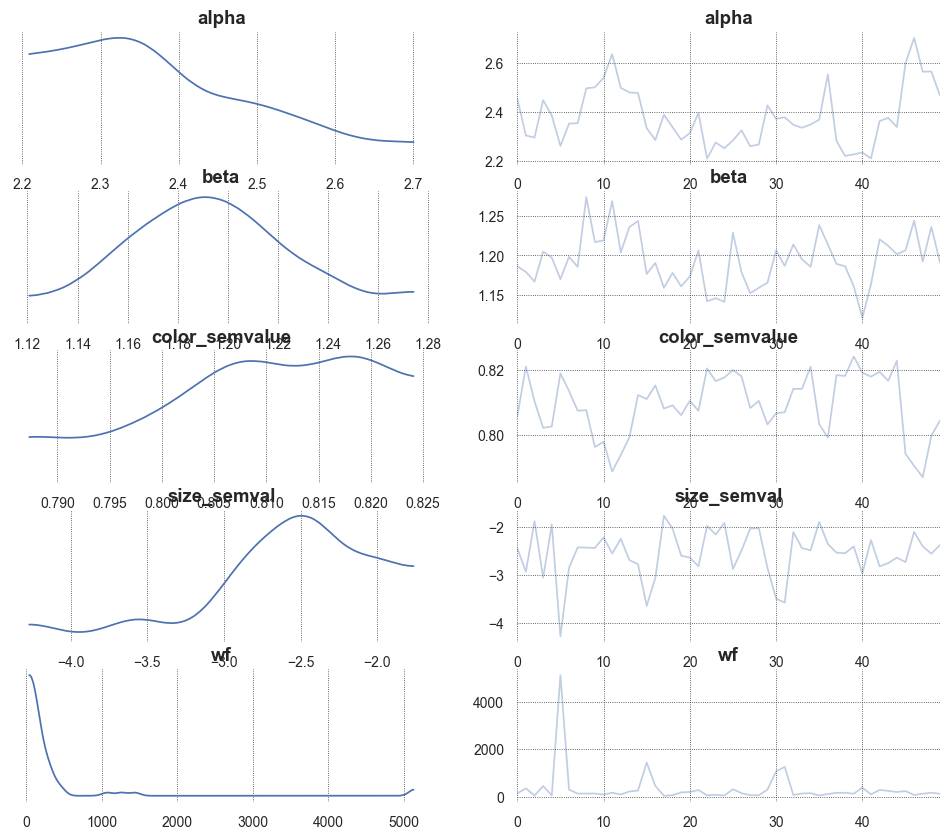

In [10]:
# Plot trace using arviz
import arviz as az
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)
plt.show()

In [12]:
from jax.random import PRNGKey
posterior_predictive = Predictive(likelihood_function_incremental_speaker, posterior_samples)(
    PRNGKey(1), states_train
)
prior = Predictive(likelihood_function_incremental_speaker, num_samples=500)(
    PRNGKey(2), states_train
)   

numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"states": np.arange(states_train.shape[0])},
    dims={"theta": ["states"]},
)

In [23]:
predictions = numpyro_data.posterior_predictive["obs"][0]

#collasped to 2 dimension
predictions.shape

summary = summarize_predictions(predictions, df, annotation_map=FLAT_TO_CATEGORIES)

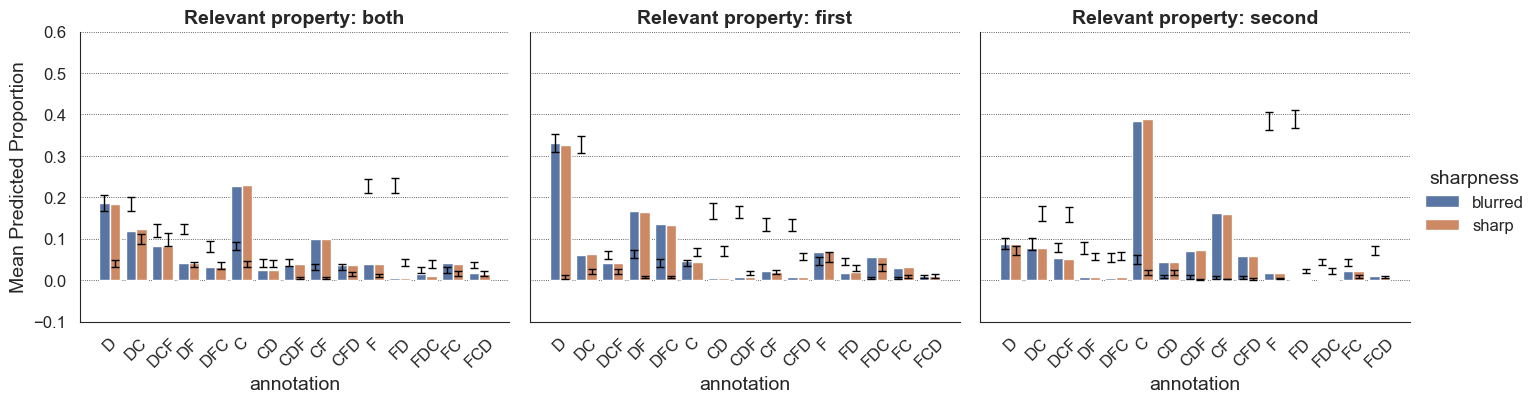

In [25]:
g = sns.catplot(
    data=summary,
    x="annotation",
    y="mean_proportion",
    hue="sharpness",
    col="relevant_property",
    kind="bar",
    height=4,
    aspect=1.2
)

g.set(ylim=(-0.1, 0.6))
g.set_xticklabels(rotation=45)
g.set_ylabels("Mean Predicted Proportion")
g.set_titles("Relevant property: {col_name}")

axes = np.ravel(g.axes)                  # flatten in case of multiple columns
col_levels = g.col_names                # which facet values we have

for ax, col_val in zip(axes, col_levels):
    sub = summary[summary["relevant_property"] == col_val]

    # Get the order seaborn uses for bars
    x_levels = [t.get_text() for t in ax.get_xticklabels()]
    hue_levels = sorted(sub["sharpness"].unique())

    # Build lookup: (annotation, sharpness) → (mean_proportion, std_proportion)
    stats = {
        (row.annotation, row.sharpness): (row.mean_proportion, row.std_proportion)
        for _, row in sub.iterrows()
    }

    # Iterate over bar patches in seaborn's order
    patch_idx = 0
    for anno in x_levels:
        for sharp in hue_levels:
            patch = ax.patches[patch_idx]
            patch_idx += 1

            if (anno, sharp) not in stats:
                continue

            mean_val, std_val = stats[(anno, sharp)]

            # bar center
            x_center = patch.get_x() + patch.get_width() / 2.0
            y = mean_val

            # error bar
            ax.errorbar(
                x_center,
                y,
                yerr=std_val,
                fmt='none',
                ecolor='black',
                elinewidth=1,
                capsize=3
            )

plt.show()